In [1]:
import pandas as pd
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
#Read The Data Tweet CSV
df = pd.read_csv("./data/data_tweet_music.csv")
df.head()

,User,Tweet
0,pjs814,RT @Melissa04899261: @Jiminlove3000 @BTS_twt B...
1,pjmmycatdog,RT @Marvicky24: BE GOOD BE LIKE JIMIN\nWITH YO...
2,chejiminie5813,RT @PJM_data: Jimin's Twitter Trends | Worldwi...
3,mlcTcdAX6jOfKC0,RT @PJMsMINI13: @charming1023 @BTS_twt My favo...
4,gortizpolly,RT @DeansMyHero: Jensen taking over the trendi...


In [7]:
#funciton to remove stop words
def remove_stopwords(lines):
    words = TextBlob(lines)
    tokens = set(words.words)
    stop = set(stopwords.words("english"))
    return tokens-stop

In [8]:
df['Tweet']= df['Tweet'].apply(remove_stopwords) # Apply remove stopwords to dataframe with coloumn Tweet
df.to_csv('data_tweet_remove_stopwords.csv') # make csv data that have data without stopwords 

In [2]:
#make spark session
spark = SparkSession.builder \
    .appName("Sentiment_Analysis") \
    .getOrCreate()

In [3]:
df = spark.read.load("./data/data_tweet_remove_stopwords.csv",
                     format="csv", inferSchema="true", header="true")

In [4]:
df.show(5,True)
df.printSchema()

+---+---------------+--------------------+
|_c0|           User|               Tweet|
+---+---------------+--------------------+
|  0|         pjs814|{'2022', 'trendin...|
|  1|    pjmmycatdog|{'OST', 'JIMIN', ...|
|  2| chejiminie5813|"{'share', 'Jimin...|
|  3|mlcTcdAX6jOfKC0|{'trending', 'cha...|
|  4|    gortizpolly|{'trending', 'top...|
+---+---------------+--------------------+
only showing top 5 rows

root
 |-- _c0: integer (nullable = true)
 |-- User: string (nullable = true)
 |-- Tweet: string (nullable = true)



In [5]:
#data cleaning
def preprocessing(lines):
    words = lines.na.replace('', None)
    words = words.na.drop()
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', r'http\\S+', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', '@\\w+', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', '#', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', 'RT', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', ':', ''))
    return words

In [6]:
# text classification
def polarity_detection(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
def text_classification(words):
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    words = words.withColumn("polarity", polarity_detection_udf("Tweet"))
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    words = words.withColumn("subjectivity", subjectivity_detection_udf("Tweet"))
    return words

In [7]:
words = preprocessing(df)
words = text_classification(words)
words = words.repartition(1)

In [8]:
words.show()

+---+---------------+--------------------+--------------------+-------------------+
|_c0|           User|               Tweet|            polarity|       subjectivity|
+---+---------------+--------------------+--------------------+-------------------+
|  0|         pjs814|{'2022', 'trendin...|               0.475| 0.7250000000000001|
|  1|    pjmmycatdog|{'OST', 'JIMIN', ...|               0.475| 0.7250000000000001|
|  2| chejiminie5813|"{'share', 'Jimin...|                 0.7| 0.6000000000000001|
|  3|mlcTcdAX6jOfKC0|{'trending', 'cha...|                0.25|               0.75|
|  4|    gortizpolly|{'trending', 'top...| 0.07499999999999998| 0.7250000000000001|
|  5|      MommyLouV|{'trending', 'Son...|                 0.0|                0.0|
|  6|      YxinBts13|{'2022', 'trendin...|               0.375| 0.7250000000000001|
|  7|Korazon24698179|"{'trying/experim...|                0.25| 0.5916666666666667|
|  8|      951013sea|{'trending', '’',...|                0.25| 0.8500000000

In [9]:
type(words)

pyspark.sql.dataframe.DataFrame

In [10]:
words = words.toPandas()
words

,_c0,User,Tweet,polarity,subjectivity
0,0,pjs814,"{'2022', 'trending', '’', 'hot', 'GOOD', 'LIKE...",0.475,0.7250000000000001
1,1,pjmmycatdog,"{'OST', 'JIMIN', 'BTSJIMIN', 'hot', '', 'BTS',...",0.475,0.7250000000000001
2,2,chejiminie5813,"""{'share', 'Jimin', 'Worldwide', 'trending', '...",0.7,0.6000000000000001
3,3,mlcTcdAX6jOfKC0,"{'trending', 'charming1023', 'favorite', 'song...",0.25,0.75
4,4,gortizpolly,"{'trending', 'topics', 't.co/mmlsSwyAQ6', '', ...",0.07499999999999998,0.7250000000000001
...,...,...,...,...,...
9995,9995,ZilBlondie,"""{'trending', """"'s""""",0.0,0.0
9996,9996,Wecantgiveup7,"""{'Song', 'Choice', 'Trending', 'BTS', """"'m""""",0.0,0.0
9997,9997,TxnTDGpqusufnrT,"{'trending', '’', 'hot', 'WithYou', 'BTS', 'OS...",0.25,0.8500000000000001
9998,9998,RADIO_CLN,"{'App', 'PopRock', 'app', 't.co/qNMaPnkBCo', '...",0.0,0.0


In [11]:
words.dtypes

_c0              int32
User            object
Tweet           object
polarity        object
subjectivity    object
dtype: object

In [12]:
words[["polarity", "subjectivity"]] = words[["polarity", "subjectivity"]].apply(pd.to_numeric)

In [13]:
# mencari rata-rata nilai polarity
mean_polarity = words['polarity'].mean()
mean_polarity

0.14650838284169534

In [14]:
tweet_polarity=[]
for i in words['polarity']:
    if i > 0 :
        i = 'Positive'
        tweet_polarity.append(i)
    elif i < 0:
        i ='Negative'
        tweet_polarity.append(i)
    else:
        i = 'Neutral'
        tweet_polarity.append(i)

In [15]:
words['type_polarity'] = tweet_polarity
words

,_c0,User,Tweet,polarity,subjectivity,type_polarity
0,0,pjs814,"{'2022', 'trending', '’', 'hot', 'GOOD', 'LIKE...",0.475000,0.725000,Positive
1,1,pjmmycatdog,"{'OST', 'JIMIN', 'BTSJIMIN', 'hot', '', 'BTS',...",0.475000,0.725000,Positive
2,2,chejiminie5813,"""{'share', 'Jimin', 'Worldwide', 'trending', '...",0.700000,0.600000,Positive
3,3,mlcTcdAX6jOfKC0,"{'trending', 'charming1023', 'favorite', 'song...",0.250000,0.750000,Positive
4,4,gortizpolly,"{'trending', 'topics', 't.co/mmlsSwyAQ6', '', ...",0.075000,0.725000,Positive
...,...,...,...,...,...,...
9995,9995,ZilBlondie,"""{'trending', """"'s""""",0.000000,0.000000,Neutral
9996,9996,Wecantgiveup7,"""{'Song', 'Choice', 'Trending', 'BTS', """"'m""""",0.000000,0.000000,Neutral
9997,9997,TxnTDGpqusufnrT,"{'trending', '’', 'hot', 'WithYou', 'BTS', 'OS...",0.250000,0.850000,Positive
9998,9998,RADIO_CLN,"{'App', 'PopRock', 'app', 't.co/qNMaPnkBCo', '...",0.000000,0.000000,Neutral


In [16]:
data_positive = words[words['type_polarity']=='Positive']['polarity'].count()
print(data_positive)

4945


In [17]:
data_negative = words[words['type_polarity']=='Negative']['polarity'].count()
print(data_negative)

439


In [18]:
data_neutral = words[words['type_polarity']=='Neutral']['polarity'].count()
print(data_neutral)

4616


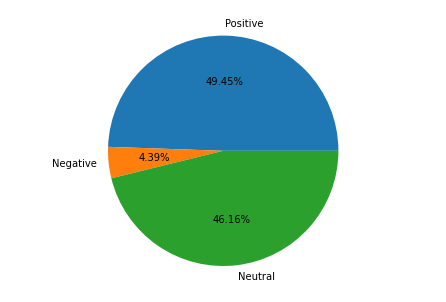

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
MataKuliah = ['Positive', 'Negative', 'Neutral']
Nilai = [data_positive,data_negative,data_neutral]
ax.pie(Nilai,labels=MataKuliah,autopct='%1.2f%%')
plt.show()

In [24]:
data_max = words.loc[words['polarity'].idxmax()]
print(data_max)
print(data_max['Tweet'])

_c0                                                            480
User                                                  Alex97674858
Tweet            {'The', 'Bio', 'King_freshh', 'reddi…', '', 'I...
polarity                                                       1.0
subjectivity                                                   0.3
type_polarity                                             Positive
Name: 480, dtype: object
{'The', 'Bio', 'King_freshh', 'reddi…', '', 'In', '•YouTube', '😍🥵💦', 'OntarioCalifornia', 'Best', 'Link', 'Click', 'kfganggg', 'Dessert', 'FYP', 'youngthug', 'Trending', 'Now•', '✅', 'rip'}


In [23]:
data_min = words.loc[words['polarity'].idxmin()]
print(data_min)
print(data_min['Tweet'])


_c0                                                           1861
User                                                KylieMareeKJMX
Tweet            {'word', 'AH', 'trending', 'The', 'th…', 'Butt...
polarity                                                      -1.0
subjectivity                                                   1.0
type_polarity                                             Negative
Name: 1861, dtype: object
{'word', 'AH', 'trending', 'The', 'th…', 'Butterflies949', '14,400', '', 'misspelling', 'scrolled', 'misspells', 'horrific', 'I', 'psycopath'}


In [25]:
data_max_s = words.loc[words['subjectivity'].idxmax()]
print(data_max_s)
print(data_max_s['Tweet'])

_c0                                                             13
User                                                 taisantosarmy
Tweet            {'trending', 'AgustD', 'favorite', 'VOTO', 'Gi...
polarity                                                       0.5
subjectivity                                                   1.0
type_polarity                                             Positive
Name: 13, dtype: object
{'trending', 'AgustD', 'favorite', 'VOTO', 'GirlOfMyDreams', '🔃', '', 'pinetreeow', '🗨️', 'SUGA', '🗳️', 'Daechwita', 'BTS_twt', 'song', 'aka'}


In [26]:
data_min_s = words.loc[words['subjectivity'].idxmin()]
print(data_min_s)
print(data_min_s['Tweet'])

_c0                                                              5
User                                                     MommyLouV
Tweet            {'trending', 'Song', 'Choice', 'Beckyg', '', '...
polarity                                                       0.0
subjectivity                                                   0.0
type_polarity                                              Neutral
Name: 5, dtype: object
{'trending', 'Song', 'Choice', 'Beckyg', '', 'CNS', 'My', 'feat', 'BTS_twt', 'laviedenoona', 'ChickenNoodleSoup', 'JHOPE'}


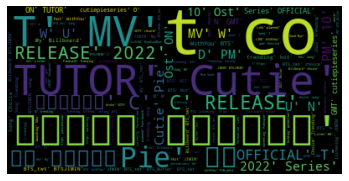

In [33]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(words[words['type_polarity']=='Positive']['Tweet']))
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

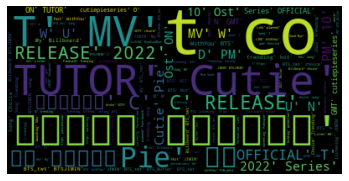

In [34]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(words[words['type_polarity']=='Negative']['Tweet']))
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

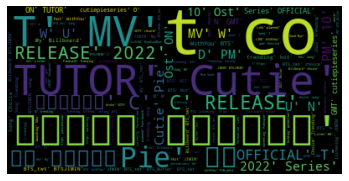

In [35]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(words[words['type_polarity']=='Neutral']['Tweet']))
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
x=[]
for a in range(0,len(words)):
    x.append(a)
words['index'] = x



In [37]:
words.head()

,_c0,User,Tweet,polarity,subjectivity,type_polarity,index
0,0,pjs814,"{'2022', 'trending', '’', 'hot', 'GOOD', 'LIKE...",0.475,0.725,Positive,0
1,1,pjmmycatdog,"{'OST', 'JIMIN', 'BTSJIMIN', 'hot', '', 'BTS',...",0.475,0.725,Positive,1
2,2,chejiminie5813,"""{'share', 'Jimin', 'Worldwide', 'trending', '...",0.700,0.600,Positive,2
3,3,mlcTcdAX6jOfKC0,"{'trending', 'charming1023', 'favorite', 'song...",0.250,0.750,Positive,3
4,4,gortizpolly,"{'trending', 'topics', 't.co/mmlsSwyAQ6', '', ...",0.075,0.725,Positive,4


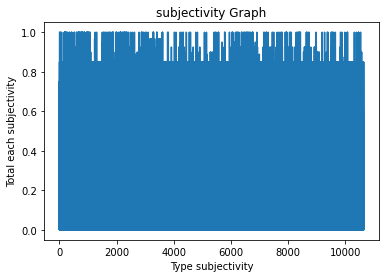

In [22]:
x = words['index']
y = words['subjectivity']

plt.plot(x, y)

# naming the x axis
plt.xlabel('Type subjectivity')
# naming the y axis
plt.ylabel('Total each subjectivity')
  
# giving a title to my graph
plt.title('subjectivity Graph')
  
# function to show the plot
plt.show()

In [23]:
# mencari rata-rata nilai subjectivity
mean_subjectivity = words['subjectivity'].mean()
mean_subjectivity

0.2647827061910537

In [24]:
spark.stop()